<a href="https://colab.research.google.com/github/dimou-gk/Cost-Optimized-Refueling-for-Fixed-Route-Fleets/blob/main/4_Fuel_Consumption_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [278]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
import itertools
!pip install pulp
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpBinary, LpStatus, value, LpContinuous

# PlanHelper

In [279]:
class Plan:
    def __init__(self,model,feature_names,target_name,filename="test_set.csv"):
        """
        This class will generate trip plans based on the test data after the trip segmentation.

        @param model: The model you trained
        @param feature_names: The features you used to train the model
        @param target_name: The target you used to train the model
        @param filename: The file name of the test set.
        """
        self.df = pd.read_csv(filename)
        self.plan_dict,self.stations=self.make_plan(longshort=80, Fuel_stations=10, random_int_trips=10)
        self.model=model
        self.feature_names=feature_names
        self.target_name=target_name
    def make_plan(self,longshort=80,Fuel_stations=10,random_int_trips=10,initmax=100):

        startposition = 0
        dflong=self.df[self.df["distance_travelled"]>longshort]
        dfshort=self.df[self.df["distance_travelled"]<longshort]

        plan=[]

        plan_dict= {}

        short_id=np.argmax(dfshort["distance_travelled"].values)
        first=dfshort.iloc[short_id]
        dfshort = dfshort.drop(dfshort.index[short_id])

        short_id2=random.randint(0, dfshort.shape[0] - 1)
        plan.append((first, dfshort.iloc[short_id2]))
        dfshort = dfshort.drop(dfshort.index[short_id2])


        for i in range(min([dfshort.shape[0],dflong.shape[0],Fuel_stations])):

            long_id=random.randint(0,dflong.shape[0]-1)

            short_id = random.randint(0, dfshort.shape[0] - 1)

            plan.append((dflong.iloc[long_id],dfshort.iloc[short_id]))
            dflong=dflong.drop(dflong.index[long_id])
            dfshort=dfshort.drop(dfshort.index[short_id])

        remaining=[]
        for i in range(dflong.shape[0]):
            remaining.append(dflong.iloc[i])
        for i in range(dfshort.shape[0]):
            remaining.append(dfshort.iloc[i])
        random.shuffle(remaining)

        #Changed this line
        for i in range(random_int_trips, len(remaining)):
            position=random.randint(0,len(plan)-1)
            plan=plan[:position]+[(remaining[i],None)]+plan[position:]

        stations= {}
        for pln in plan:
            startposition+= pln[0]["distance_travelled"]
            plan_dict[startposition]=pln
            if pln[1] is not None:
                stations[startposition]=pln[1]
        return plan_dict,stations

    def get_main_road_trips(self,from_km,to_km):
        trips = []
        shorted_keys = sorted(self.plan_dict.keys())
        for i in range(len(shorted_keys)):
            if shorted_keys[i] > from_km and shorted_keys[i] <= to_km:
                trips.append(self.plan_dict[shorted_keys[i]][0])
        return trips
    def get_extra_to_station_trip(self,km):
        if km in self.stations.keys():
            return self.stations[km]
        else:
            return None
    def stations_km(self):
        return_stations=[]
        for key in self.stations.keys():
            return_stations.append(key)
        return_stations.sort()
        return return_stations



    def predict(self, trips):
        estimations = []
        for trip in trips:
            x = trip[self.feature_names]
            # print(x.values)
            estimation = self.model.predict(np.array([x.values]))
            estimations.append(estimation[0])
        return estimations

    def real_consumption(self,trips):
        estimations = []
        for trip in trips:
            estimations.append(trip[self.target_name])
        return estimations
    def real_Consumption_form_to(self, from_km, to_km):
        """
        This function will return the REAL consumption from Kilometer 'from_km' until 'to_km'
        Note that this not include the consumption for reaching station.
        """
        trips = self.get_main_road_trips(from_km, to_km)
        return sum(self.real_consumption(trips))
    def Consumption_form_to(self, from_km, to_km):
        """
        This function will return the estimation of consumption from Kilometer 'from_km' until 'to_km'
        Note that this not include the consumption for reaching station.
        """
        trips = self.get_main_road_trips(from_km, to_km)
        return sum(self.predict(trips))

    def Extra_consumption_to_reach_station(self, km):
        """
        This function will return the estimation of consumption of the EXTRA distance to reach a Fuel station from kilometer km
        """
        trips = [self.get_extra_to_station_trip(km)]
        return sum(self.predict(trips))
    def Extra_real_consumption_to_reach_station(self, km):
        """
        This function will return the REAL consumption of the EXTRA distance to reach a Fuel station from kilometer km
        """
        trips = [self.get_extra_to_station_trip(km)]
        return sum(self.real_consumption(trips))


def train_model(features, target, model):
    feature_names = features
    target_name = target
    final_result=pd.read_csv("train_test_set.csv")
    train_set = final_result[final_result["split"] == "train"]
    intX=train_set[feature_names+[target_name]].replace([np.inf, -np.inf], np.nan).dropna()
    X = intX[feature_names].values
    y1 = intX[target_name]
    model = model
    model.fit(X, y1)

    # dft = pd.read_csv("test_set.csv")
    # dftintX=dft[feature_names+[target_name]].replace([np.inf, -np.inf], np.nan).dropna()
    # X = dftintX[feature_names]
    # y1 = dftintX[target_name]
    # from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
    # y_pred_test = model.predict(X)
    # mae_test = mean_absolute_percentage_error(y1, y_pred_test)
    # plt.plot(y1.values)
    # plt.plot(y_pred_test)
    # plt.show()
    # print(f'Mean Absolute Error (MAE) on the Test Set: {mae_test}')

    return model

# Setup

In [280]:
#Hardcoded model from previous notebook
model = Lasso(alpha= 0.1)
df_test = pd.read_csv("test_data.csv")
feature_names = df_test.drop(columns=['lit_per_100km']).columns.to_list()
target_name = 'lit_per_100km'
filename = "test_data.csv"

ConsumptionModel=train_model(feature_names, target_name, model)

plan = Plan(model, feature_names, target_name, filename)

station_points=plan.stations_km()
print(f"Positions of Stations: {station_points}")

Positions of Stations: [np.float64(73.7), np.float64(378.485), np.float64(682.03), np.float64(1309.34), np.float64(1851.8), np.float64(2087.305)]


In [281]:
# print()
# print()
# print("EXAMPLE 1:")
# print("Consumption for reaching the station 0:")
# print(f"Consumption from beginning until km of the station:",plan.Consumption_form_to(0,station_points[0]))
# print(f"Consumption of Extra trip:",plan.Extra_consumption_to_reach_station(station_points[0]))
# print(f"Total: ",plan.Consumption_form_to(0,station_points[0])+plan.Extra_consumption_to_reach_station(station_points[0]))
# print(f"Actual Consumption: ",plan.real_Consumption_form_to(0, station_points[0]) + plan.Extra_real_consumption_to_reach_station(station_points[0]))
# print()
# print()
# print("EXAMPLE 2:")
# print("Consumption for reaching the station 1 (without stopping at station 0):")
# print(f"Consumption from beginning until km of the station 1 :", plan.Consumption_form_to(0, station_points[1]))
# print(f"Consumption of Extra trip:", plan.Extra_consumption_to_reach_station(station_points[1]))
# print(f"Total: ",plan.Consumption_form_to(0, station_points[1]) + plan.Extra_consumption_to_reach_station(station_points[1]))
# print(f"Actual Consumption: ",plan.real_Consumption_form_to(0, station_points[1]) + plan.Extra_real_consumption_to_reach_station(station_points[1]))

# ComparePlans

In [282]:
# ## Plan A
# FuelTank = 150
# TankLimit = 300
# Fuel_spending = 0
# print("========= PLAN A ===========")
# print(f"Consumption from beginning until first of the station:", plan.Consumption_form_to(0, station_points[0]))
# print(f"Extra Consumption :", plan.Extra_consumption_to_reach_station( station_points[0]))

# Fuel_spending+=plan.Consumption_form_to(0, station_points[0])+plan.Extra_consumption_to_reach_station(station_points[0])

# FuelTank-=plan.Consumption_form_to(0, station_points[0])+plan.Extra_consumption_to_reach_station(station_points[0])

# print(f"Fuel Tank after reaching station 0: {FuelTank}")
# FuelTank=TankLimit
# print(f"Refueling: Fuel Tank = {FuelTank}")

# print(f"Consumption from station 0 until the last station", plan.Consumption_form_to(station_points[0], station_points[2]))
# Fuel_spending +=  plan.Consumption_form_to(station_points[0], station_points[2])
# FuelTank-=plan.Consumption_form_to(station_points[0], station_points[2])
# print(f"Fuel Tank = {FuelTank}")
# print(f"Estimation: Total Fuel spent = {Fuel_spending}")

# print("========= PLAN A ACTUAL===========")
# FuelTank = 150
# TankLimit = 300
# Fuel_spending = 0
# print(f"Consumption from beginning until first of the station:", plan.real_Consumption_form_to(0, station_points[0]))
# print(f"Extra Consumption :", plan.Extra_real_consumption_to_reach_station(station_points[0]))

# Fuel_spending += plan.real_Consumption_form_to(0, station_points[0]) + plan.Extra_real_consumption_to_reach_station(station_points[0])

# FuelTank -= plan.real_Consumption_form_to(0, station_points[0]) + plan.Extra_real_consumption_to_reach_station(station_points[0])

# print(f"Fuel Tank after reaching station 0: {FuelTank}")
# FuelTank = TankLimit
# print(f"Refueling: Fuel Tank = {FuelTank}")

# print(f"Consumption from station 0 until the last station",plan.real_Consumption_form_to(station_points[0], station_points[2]))
# Fuel_spending += plan.real_Consumption_form_to(station_points[0], station_points[2])
# FuelTank -= plan.real_Consumption_form_to(station_points[0], station_points[2])
# print(f"Fuel Tank = {FuelTank}")
# print(f"Estimation: Total Fuel spent = {Fuel_spending}")

# ## Plan B
# FuelTank = 150
# TankLimit = 300
# Fuel_spending = 0
# print("========= PLAN B ===========")


# print(f"Consumption from beginning until second station:", plan.Consumption_form_to(0, station_points[1]))
# print(f"Extra Consumption :", plan.Extra_consumption_to_reach_station(station_points[1]))

# Fuel_spending += plan.Consumption_form_to(0, station_points[1]) + plan.Extra_consumption_to_reach_station(station_points[1])
# FuelTank -= plan.Consumption_form_to(0, station_points[1]) + plan.Extra_consumption_to_reach_station(station_points[1])

# print(f"Fuel Tank after reaching station 1: {FuelTank}")
# FuelTank = TankLimit
# print(f"Refueling: Fuel Tank = {FuelTank}")

# print(f"Consumption from station 1 until the last station",plan.Consumption_form_to(station_points[1], station_points[2]))
# Fuel_spending += plan.Consumption_form_to(station_points[1], station_points[2])
# FuelTank -= plan.Consumption_form_to(station_points[1], station_points[2])
# print(f"Fuel Tank = {FuelTank}")
# print(f"Estimation: Total Fuel spent = {Fuel_spending}")


# print("========= PLAN B Actual===========")
# FuelTank = 150
# TankLimit = 300
# Fuel_spending = 0
# print(f"Consumption from beginning until second station:", plan.real_Consumption_form_to(0, station_points[1]))
# print(f"Extra Consumption :", plan.Extra_real_consumption_to_reach_station(station_points[1]))

# Fuel_spending += plan.real_Consumption_form_to(0, station_points[1]) + plan.Extra_real_consumption_to_reach_station(
#     station_points[1])
# FuelTank -= plan.real_Consumption_form_to(0, station_points[1]) + plan.Extra_real_consumption_to_reach_station(
#     station_points[1])

# print(f"Fuel Tank after reaching station 1: {FuelTank}")
# FuelTank = TankLimit
# print(f"Refueling: Fuel Tank = {FuelTank}")

# print(f"Consumption from station 1 until the last station",
#       plan.real_Consumption_form_to(station_points[1], station_points[2]))
# Fuel_spending += plan.real_Consumption_form_to(station_points[1], station_points[2])
# FuelTank -= plan.real_Consumption_form_to(station_points[1], station_points[2])
# print(f"Fuel Tank = {FuelTank}")
# print(f"Estimation: Total Fuel spent = {Fuel_spending}")

# Approaches

Try 3 different methods. Greedy and Cartessian which are not Optimization methods but take a greedy path and follow it to the end and compare all possible results using Cartessian product and select the best.

## Greedy Approach - Consider only one Plan

In [283]:
def find_greedy_plan(plan: Plan, max_fuel: float = 300, start_fuel: float = 150, use_real: bool = False):
    """
    Greedy strategy: refuel only when the next station cannot be reached.

    Parameters:
    - plan: Plan instance
    - max_fuel: max tank capacity
    - start_fuel: initial fuel at start
    - use_real: use real consumption if True, else use predicted

    Returns:
    - selected_stations: list of station km positions where we stop to refuel
    - log: list of tuples (from_km, to_km, fuel_used)
    - ran_out: True if we would run out of fuel, False otherwise
    """
    stations = plan.stations_km()
    selected_stations = []
    log = []
    fuel = start_fuel
    current_km = 0
    ran_out = False

    # Choose the appropriate method
    consumption_fn = plan.real_Consumption_form_to if use_real else plan.Consumption_form_to
    extra_fn = plan.Extra_real_consumption_to_reach_station if use_real else plan.Extra_consumption_to_reach_station

    for i, station_km in enumerate(stations):
        fuel_needed = consumption_fn(current_km, station_km) + extra_fn(station_km)

        if fuel_needed > fuel:
            # Can't reach this station, refuel at previous
            if not selected_stations and i == 0:
                print("Cannot reach the first station!")
                ran_out = True
                break
            prev_station = stations[i - 1]
            selected_stations.append(prev_station)
            current_km = prev_station
            fuel = max_fuel
            fuel_needed = consumption_fn(current_km, station_km) + extra_fn(station_km)

            if fuel_needed > fuel:
                print(f"Still can't reach station at km {station_km} after refueling at km {prev_station}.")
                ran_out = True
                break
        fuel -= fuel_needed
        log.append((current_km, station_km, fuel_needed))
        current_km = station_km

    return selected_stations, log, ran_out

In [284]:
def evaluate_plan(plan: Plan):
    model_plan, model_log, model_fail = find_greedy_plan(plan, use_real=False)
    real_plan, real_log, real_fail = find_greedy_plan(plan, use_real=True)

    print("\n=== MODEL PLAN ===")
    print("Stops at stations:", model_plan)
    print("Fuel log (from_km, to_km, used):")
    for leg in model_log:
        print(leg)
    print("Ran out of fuel (model)?", model_fail)

    print("\n=== ACTUAL PLAN ===")
    print("Stops at stations:", real_plan)
    print("Fuel log (from_km, to_km, used):")
    for leg in real_log:
        print(leg)
    print("Ran out of fuel (actual)?", real_fail)

    print("\n=== COMPARISON ===")
    if model_plan == real_plan:
        print("The model and real plans choose the same stations.")
    else:
        print("The model and real plans differ.")
    if model_fail:
        print("The model's plan would leave the vehicle stranded!")

In [285]:
evaluate_plan(plan)


=== MODEL PLAN ===
Stops at stations: [np.float64(378.485)]
Fuel log (from_km, to_km, used):
(0, np.float64(73.7), np.float64(62.95815780558273))
(np.float64(73.7), np.float64(378.485), np.float64(56.622800929278405))
(np.float64(378.485), np.float64(682.03), np.float64(72.28160949044212))
(np.float64(682.03), np.float64(1309.34), np.float64(93.23047473825562))
(np.float64(1309.34), np.float64(1851.8), np.float64(64.15867605085998))
(np.float64(1851.8), np.float64(2087.305), np.float64(63.99998949588821))
Ran out of fuel (model)? False

=== ACTUAL PLAN ===
Stops at stations: [np.float64(378.485), np.float64(1851.8)]
Fuel log (from_km, to_km, used):
(0, np.float64(73.7), np.float64(64.2339801))
(np.float64(73.7), np.float64(378.485), np.float64(34.643298591000004))
(np.float64(378.485), np.float64(682.03), np.float64(77.49391948))
(np.float64(682.03), np.float64(1309.34), np.float64(97.91149873))
(np.float64(1309.34), np.float64(1851.8), np.float64(64.95834599))
(np.float64(1851.8), np

In [286]:
def plot_fuel_comparison(plan: Plan):
    model_plan, model_log, model_fail = find_greedy_plan(plan, use_real=False)
    real_plan, real_log, real_fail = find_greedy_plan(plan, use_real=True)

    # Prepare data
    model_segments = [f"{start}-{end}" for (start, end, _) in model_log]
    model_fuel = [used for (_, _, used) in model_log]

    real_segments = [f"{start}-{end}" for (start, end, _) in real_log]
    real_fuel = [used for (_, _, used) in real_log]

    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.35
    x = range(len(model_segments))

    ax.bar(x, model_fuel, width=width, label='Predicted Consumption', color='skyblue')
    ax.bar([i + width for i in x], real_fuel, width=width, label='Actual Consumption', color='orange')

    # Add x-axis labels and rotate
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(model_segments, rotation=45)
    ax.set_ylabel('Fuel Consumption (liters)')
    ax.set_title('Fuel Consumption Per Trip Segment')
    ax.legend()

    # Annotate warnings
    if model_fail:
        plt.figtext(0.5, 0.01, "WARNING: Model plan could result in running out of fuel!", ha='center', color='red', fontsize=12)
    elif real_fail:
        plt.figtext(0.5, 0.01, "WARNING: Real consumption would lead to fuel shortage!", ha='center', color='darkorange', fontsize=12)
    else:
        plt.figtext(0.5, 0.01, "Safe: Both model and actual plans avoid fuel depletion.", ha='center', color='green', fontsize=12)

    plt.tight_layout()
    plt.show()

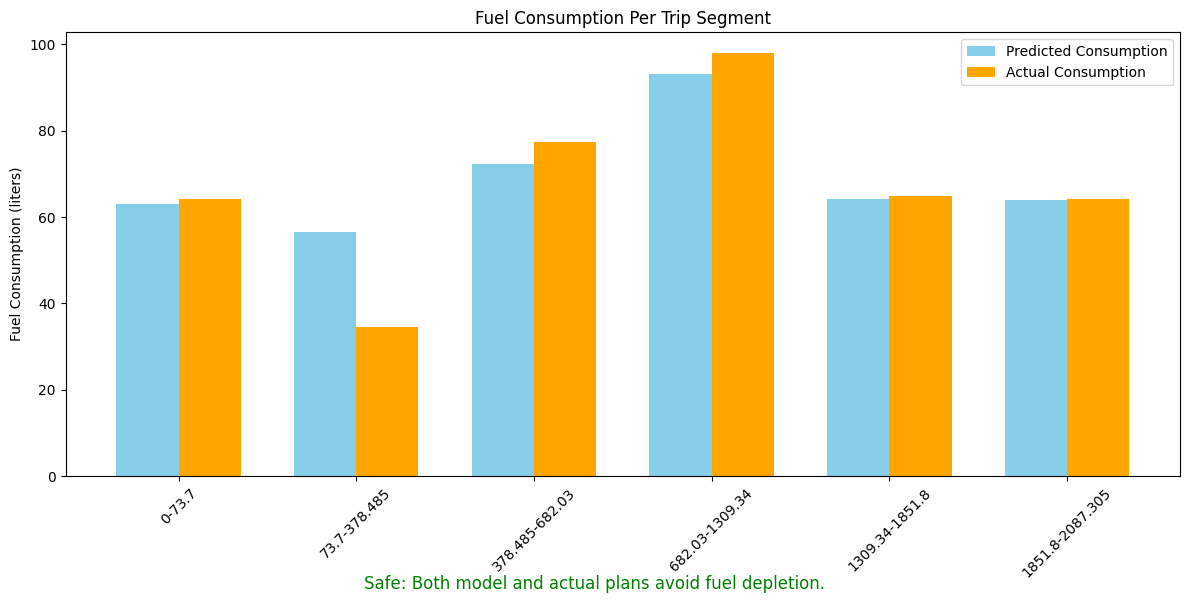

In [287]:
plot_fuel_comparison(plan)

## Cartessian Plan Search - Search all available Plans

In [288]:
def find_optimal_plan(plan, Fuel_Tank_Start = 150, Tank_Limit = 300):
    station_points = plan.stations_km()
    FuelTankStart = Fuel_Tank_Start
    TankLimit = Tank_Limit
    best_plan = None
    min_consumption = float('inf')

    # Try all combinations of refueling stations (including none)
    for r in range(len(station_points) + 1):
        for refuel_stations in itertools.combinations(station_points, r):
            FuelTank = FuelTankStart
            FuelSpent = 0
            current_km = 0
            success = True

            for stop_km in list(refuel_stations) + [station_points[-1]]:  # Always end at the last station
                try:
                    # Estimate consumption to get from current_km to stop_km
                    trip_consumption = plan.Consumption_form_to(current_km, stop_km)
                    extra_consumption = 0
                    if stop_km in refuel_stations:
                        extra_consumption = plan.Extra_consumption_to_reach_station(stop_km)

                    total_segment_consumption = trip_consumption + extra_consumption

                    if FuelTank < total_segment_consumption:
                        success = False
                        break  # This plan doesn't work

                    # Deduct fuel
                    FuelTank -= total_segment_consumption
                    FuelSpent += total_segment_consumption
                    current_km = stop_km

                    # Refuel if this stop is a refueling station
                    if stop_km in refuel_stations:
                        FuelTank = TankLimit  # Refill tank
                except:
                    success = False
                    break

            if success and FuelSpent < min_consumption:
                min_consumption = FuelSpent
                best_plan = list(refuel_stations)

    print(f"Optimal plan: stop at stations {best_plan}")
    print(f"Estimated total fuel consumption: {min_consumption:.2f}")
    return best_plan

In [289]:
def print_plan_summary(plan, refuel_stations, Fuel_Tank_Start = 150, Tank_Limit = 300):
    station_points = plan.stations_km()
    FuelTank = Fuel_Tank_Start
    TankLimit = Tank_Limit
    current_km = 0
    total_fuel = 0.0

    print("\n JOURNEY SUMMARY")
    print("-" * 40)
    for stop_km in list(refuel_stations) + [station_points[-1]]:
        trip = plan.Consumption_form_to(current_km, stop_km)
        extra = plan.Extra_consumption_to_reach_station(stop_km) if stop_km in refuel_stations else 0
        total_segment = trip + extra

        print(f" From {current_km:.1f} km to {stop_km:.1f} km")
        print(f"   Trip Consumption: {trip:.2f} L")
        if extra > 0:
            print(f"   Detour to Refuel: +{extra:.2f} L")
        print(f"   Total Segment: {total_segment:.2f} L")

        FuelTank -= total_segment
        if FuelTank < 0:
            print("Not enough fuel — INVALID PLAN!")
            return

        total_fuel += total_segment
        current_km = stop_km

        if stop_km in refuel_stations:
            print(f"Refueled to {TankLimit} L")
            FuelTank = TankLimit

        print(f"Fuel Remaining: {FuelTank:.2f} L")
        print("-" * 40)

    print(f"\nTotal Estimated Fuel Consumption: {total_fuel:.2f} L")
    print(f"Final Fuel Left in Tank: {FuelTank:.2f} L")

In [290]:
def plot_fuel_profile(plan, refuel_stations):
    station_points = plan.stations_km()
    FuelTank = 150
    TankLimit = 300
    current_km = 0
    fuel_levels = [FuelTank]
    kms = [0]

    for stop_km in list(refuel_stations) + [station_points[-1]]:
        trip = plan.Consumption_form_to(current_km, stop_km)
        extra = plan.Extra_consumption_to_reach_station(stop_km) if stop_km in refuel_stations else 0
        consumption = trip + extra

        FuelTank -= consumption
        current_km = stop_km
        kms.append(current_km)
        fuel_levels.append(FuelTank)

        if stop_km in refuel_stations:
            FuelTank = TankLimit
            kms.append(current_km)
            fuel_levels.append(FuelTank)

    plt.figure(figsize=(12, 6))
    plt.plot(kms, fuel_levels, marker='o', label='Fuel Level')
    for s in station_points:
        plt.axvline(x=s, color='gray', linestyle='--', alpha=0.3)
    for r in refuel_stations:
        plt.axvline(x=r, color='green', linestyle='-', label='Refuel' if r == refuel_stations[0] else "")

    plt.title("Truck Fuel Level Over Journey")
    plt.xlabel("Distance (km)")
    plt.ylabel("Fuel in Tank (L)")
    plt.legend()
    plt.grid(True)
    plt.show()

Optimal plan: stop at stations [np.float64(378.485)]
Estimated total fuel consumption: 236.15

 JOURNEY SUMMARY
----------------------------------------
 From 0.0 km to 378.5 km
   Trip Consumption: 53.17 L
   Detour to Refuel: +31.25 L
   Total Segment: 84.41 L
Refueled to 300 L
Fuel Remaining: 300.00 L
----------------------------------------
 From 378.5 km to 2087.3 km
   Trip Consumption: 151.74 L
   Total Segment: 151.74 L
Fuel Remaining: 148.26 L
----------------------------------------

Total Estimated Fuel Consumption: 236.15 L
Final Fuel Left in Tank: 148.26 L


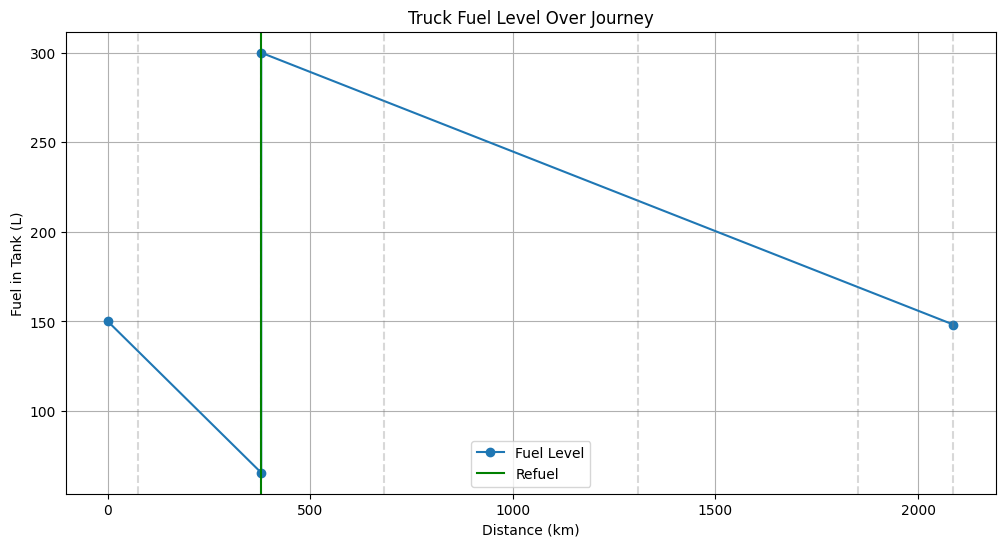

In [291]:
optimal_plan = find_optimal_plan(plan)
print_plan_summary(plan, optimal_plan)
plot_fuel_profile(plan, optimal_plan)

In [292]:
def compare_all_plans(plan, max_stops=3):
    stations = plan.stations_km()[:-1]  # intermediate stations
    destination = plan.stations_km()[-1]

    TankLimit = 300
    InitialFuel = 150

    all_results = []

    for r in range(0, max_stops + 1):  # try all combinations with 0 to max_stops
        for stops in itertools.combinations(stations, r):
            journey = list(stops) + [destination]

            # Estimate
            est_fuel = 0
            fuel = InitialFuel
            pos = 0
            valid = True

            for stop in journey:
                try:
                    segment = plan.Consumption_form_to(pos, stop)
                    extra = plan.Extra_consumption_to_reach_station(stop) if stop in stops else 0
                    used = segment + extra

                    if used > fuel:
                        valid = False
                        break
                    fuel -= used
                    est_fuel += used

                    if stop in stops:
                        fuel = TankLimit
                    pos = stop
                except:
                    valid = False
                    break

            if not valid:
                continue

            # Actual
            real_fuel = 0
            fuel = InitialFuel
            pos = 0

            for stop in journey:
                seg_real = plan.real_Consumption_form_to(pos, stop)
                extra_real = plan.Extra_real_consumption_to_reach_station(stop) if stop in stops else 0
                used = seg_real + extra_real
                fuel -= used
                real_fuel += used
                if stop in stops:
                    fuel = TankLimit
                pos = stop

            all_results.append({
                "stops": stops,
                "estimated": round(est_fuel, 2),
                "actual": round(real_fuel, 2)
            })

    return sorted(all_results, key=lambda x: x['estimated'])

In [293]:
plans = compare_all_plans(plan)

for i, result in enumerate(plans):
    stops_km = ", ".join(str(s) for s in result['stops']) or "No Stops"
    print(f"Plan {i+1}: Stops at [{stops_km}]")
    print(f"  Estimated Fuel: {result['estimated']} units")
    print(f"  Actual Fuel:    {result['actual']} units")
    print("  ----------------------")

Plan 1: Stops at [378.485]
  Estimated Fuel: 236.15 units
  Actual Fuel:    211.64 units
  ----------------------
Plan 2: Stops at [682.03]
  Estimated Fuel: 238.82 units
  Actual Fuel:    236.75 units
  ----------------------
Plan 3: Stops at [73.7]
  Estimated Fuel: 240.07 units
  Actual Fuel:    238.98 units
  ----------------------
Plan 4: Stops at [378.485, 1851.8]
  Estimated Fuel: 268.37 units
  Actual Fuel:    242.72 units
  ----------------------
Plan 5: Stops at [378.485, 682.03]
  Estimated Fuel: 270.07 units
  Actual Fuel:    246.44 units
  ----------------------
Plan 6: Stops at [682.03, 1851.8]
  Estimated Fuel: 271.04 units
  Actual Fuel:    267.83 units
  ----------------------
Plan 7: Stops at [73.7, 378.485]
  Estimated Fuel: 271.32 units
  Actual Fuel:    248.67 units
  ----------------------
Plan 8: Stops at [73.7, 1851.8]
  Estimated Fuel: 272.29 units
  Actual Fuel:    270.06 units
  ----------------------
Plan 9: Stops at [73.7, 682.03]
  Estimated Fuel: 273.99 u

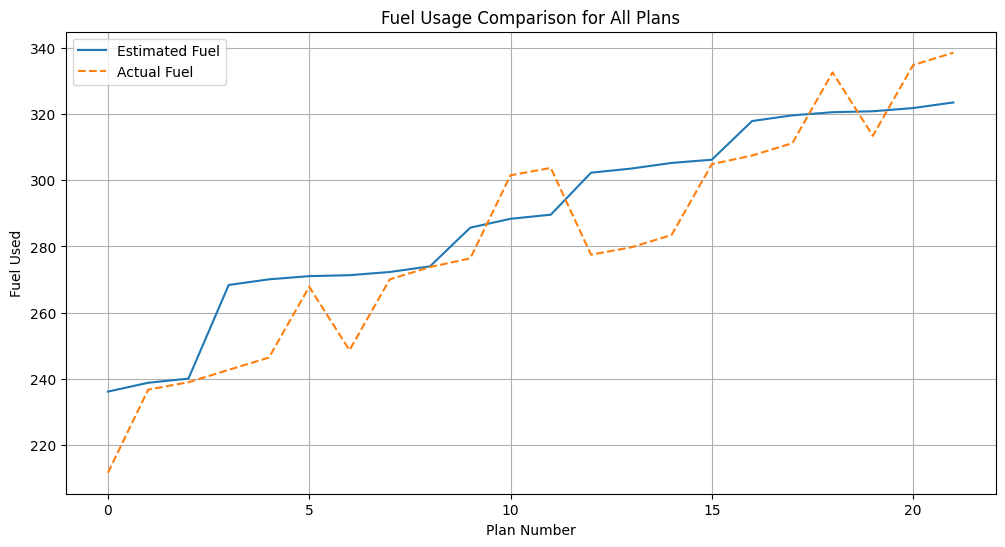

In [294]:
x = list(range(len(plans)))
est = [p['estimated'] for p in plans]
real = [p['actual'] for p in plans]

plt.figure(figsize=(12,6))
plt.plot(x, est, label="Estimated Fuel")
plt.plot(x, real, label="Actual Fuel", linestyle='--')
plt.xlabel("Plan Number")
plt.ylabel("Fuel Used")
plt.title("Fuel Usage Comparison for All Plans")
plt.legend()
plt.grid(True)
plt.show()

In [295]:
def simulate_all_detailed_plans(plan, max_stops=3):
    stations = plan.stations_km()[:-1]
    destination = plan.stations_km()[-1]
    TankLimit = 300
    InitialFuel = 150

    results = []
    plan_number = 1

    for r in range(0, max_stops + 1):
        for stops in itertools.combinations(stations, r):
            journey = list(stops) + [destination]

            # ======= Simulate Estimated Plan =======
            FuelTank = InitialFuel
            Fuel_spending = 0
            pos = 0
            valid = True
            steps_estimated = []

            for stop in journey:
                try:
                    segment = plan.Consumption_form_to(pos, stop)
                    extra = plan.Extra_consumption_to_reach_station(stop) if stop in stops else 0
                    used = segment + extra

                    if used > FuelTank:
                        valid = False
                        break

                    step = f"From {pos} → {stop}:\n" \
                           f"  - Consumption: {segment}\n" \
                           f"  - Extra: {extra}\n" \
                           f"  - Used: {used}\n" \
                           f"  - Tank Before: {FuelTank}"

                    FuelTank -= used
                    Fuel_spending += used
                    step += f"\n  - Tank After: {FuelTank}"

                    if stop in stops:
                        FuelTank = TankLimit
                        step += f"\n  - Refueled to: {FuelTank}"
                    pos = stop

                    steps_estimated.append(step)
                except:
                    valid = False
                    break

            if not valid:
                continue

            # ======= Simulate Actual Plan =======
            FuelTank = InitialFuel
            Fuel_spending_actual = 0
            pos = 0
            steps_actual = []

            for stop in journey:
                segment = plan.real_Consumption_form_to(pos, stop)
                extra = plan.Extra_real_consumption_to_reach_station(stop) if stop in stops else 0
                used = segment + extra

                step = f"From {pos} → {stop}:\n" \
                       f"  - Real Consumption: {segment}\n" \
                       f"  - Real Extra: {extra}\n" \
                       f"  - Used: {used}\n" \
                       f"  - Tank Before: {FuelTank}"

                FuelTank -= used
                Fuel_spending_actual += used
                step += f"\n  - Tank After: {FuelTank}"

                if stop in stops:
                    FuelTank = TankLimit
                    step += f"\n  - Refueled to: {FuelTank}"

                pos = stop
                steps_actual.append(step)

            # ======= Print Plan =======
            print(f"\n========= PLAN {plan_number} - Estimated =========")
            for s in steps_estimated:
                print(s)
                print()
            print(f"Estimated Total Fuel: {round(Fuel_spending, 2)}")

            print(f"\n========= PLAN {plan_number} - Actual =========")
            for s in steps_actual:
                print(s)
                print()
            print(f"Actual Total Fuel: {round(Fuel_spending_actual, 2)}")

            print("\n" + "=" * 40 + "\n")

            plan_number += 1

In [296]:
simulate_all_detailed_plans(plan, max_stops=2)


========= PLAN 1 - Estimated =========
From 0 → 73.7:
  - Consumption: 27.790769365818278
  - Extra: 35.16738843976445
  - Used: 62.95815780558273
  - Tank Before: 150
  - Tank After: 87.04184219441727
  - Refueled to: 300

From 73.7 → 2087.305:
  - Consumption: 177.11179252778993
  - Extra: 0
  - Used: 177.11179252778993
  - Tank Before: 300
  - Tank After: 122.88820747221007

Estimated Total Fuel: 240.07

========= PLAN 1 - Actual =========
From 0 → 73.7:
  - Real Consumption: 27.2039801
  - Real Extra: 37.03
  - Used: 64.2339801
  - Tank Before: 150
  - Tank After: 85.7660199
  - Refueled to: 300

From 73.7 → 2087.305:
  - Real Consumption: 174.74557261
  - Real Extra: 0
  - Used: 174.74557261
  - Tank Before: 300
  - Tank After: 125.25442738999999

Actual Total Fuel: 238.98



========= PLAN 2 - Estimated =========
From 0 → 378.485:
  - Consumption: 53.16540870396099
  - Extra: 31.24816159113569
  - Used: 84.41357029509669
  - Tank Before: 150
  - Tank After: 65.58642970490331
  -

## Multi-Objective Optimization Approach

In [297]:
def build_segment_dataframe(plan):
    """
    Constructs a DataFrame containing all possible route segments between
    fuel stations (including the starting point) using the given Plan object.

    Each segment includes:
        - starting point (from)
        - ending point (to)
        - estimated fuel consumption (fuel)
        - estimated travel duration in minutes (duration_min)

    This data can be used for route optimization (e.g., linear programming).

    @param plan: A Plan object that provides trip segment data and prediction methods.
    @return: A pandas DataFrame with route segments and their associated costs.
    """

    stations = [0] + plan.stations_km()  # Include starting point
    segments_data = []

    for i, from_km in enumerate(stations[:-1]):
        for to_km in stations[i+1:]:
            # Estimate fuel and time between from_km and to_km
            try:
                trips = plan.get_main_road_trips(from_km, to_km)
                if not trips:
                    continue

                estimated_fuel = plan.Consumption_form_to(from_km, to_km)
                total_duration = sum(trip["duration_min"] for trip in trips)

                segments_data.append({
                    "from": from_km,
                    "to": to_km,
                    "fuel": estimated_fuel,
                    "duration_min": total_duration
                })
            except Exception as e:
                print(f"Skipping {from_km} → {to_km} due to error: {e}")
                continue

    return pd.DataFrame(segments_data)

In [298]:
segments_df = build_segment_dataframe(plan)

segments_df['fuel_scaled'] = (segments_df['fuel'] - segments_df['fuel'].min()) / (segments_df['fuel'].max() - segments_df['fuel'].min())
segments_df['duration_scaled'] = (segments_df['duration_min'] - segments_df['duration_min'].min()) / (segments_df['duration_min'].max() - segments_df['duration_min'].min())

print(segments_df.head())

   from        to        fuel  duration_min  fuel_scaled  duration_scaled
0   0.0    73.700   27.790769    130.183333     0.013458         0.000000
1   0.0   378.485   53.165409    374.533333     0.154799         0.103970
2   0.0   682.030   91.524742    621.533333     0.368467         0.209067
3   0.0  1309.340  135.223211   1493.050000     0.611875         0.579894
4   0.0  1851.800  167.164269   2265.100000     0.789792         0.908398


In [299]:
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpBinary, LpStatus, value

# Define weights
# alpha = 1.0  # weight for fuel
# beta = 0.01  # weight for time (scaled to match fuel units)
#Define the weights in proportion to how much they account in recent reports  (https://gomotive.com/blog/trucking-operational-costs/)
alpha = 0.4
beta = 0.3

# Create the problem
prob = LpProblem("Optimal_Refueling_Route", LpMinimize)

# Decision variables: x[i, j] = 1 if we take the path from i to j
x = {
    (row['from'], row['to']): LpVariable(f"x_{row['from']}_{row['to']}", cat=LpBinary)
    for _, row in segments_df.iterrows()
}


# Objective: weighted sum of fuel and time
# prob += lpSum([
#     x[i, j] * (alpha * row['fuel'] + beta * row['duration_min'])
#     for (i, j), row in segments_df.set_index(['from', 'to']).iterrows()
# ])

#Objective: weighted sum of fuel and time (scaled)
prob += lpSum([
    x[i, j] * (alpha * row['fuel_scaled'] + beta * row['duration_scaled'])
    for (i, j), row in segments_df.set_index(['from', 'to']).iterrows()
])

# Constraint: start at node 0
prob += lpSum([x[i, j] for (i, j) in x if i == 0]) == 1, "StartConstraint"

# Constraint: end at the final node (e.g., 3)
end_node = segments_df['to'].max()
prob += lpSum([x[i, j] for (i, j) in x if j == end_node]) == 1, "EndConstraint"

# Flow conservation: for each intermediate node, in == out
nodes = set(segments_df['from']).union(set(segments_df['to']))
intermediate_nodes = nodes - {0, end_node}
for node in intermediate_nodes:
    prob += (
        lpSum([x[i, j] for (i, j) in x if j == node]) ==
        lpSum([x[i, j] for (i, j) in x if i == node]),
        f"FlowConservation_{node}"
    )

# Solve
prob.solve()

# Results
print(f"Status: {LpStatus[prob.status]}")
print("Optimal Route:")
for (i, j), var in x.items():
    if var.varValue == 1:
        print(f"{i} -> {j}")
print(f"Total Weighted Cost: {value(prob.objective)}")

Status: Optimal
Optimal Route:
0.0 -> 73.7
73.7 -> 378.485
378.485 -> 682.03
682.03 -> 1309.34
1309.34 -> 1851.8
1851.8 -> 2087.305
Total Weighted Cost: 0.33422951347076946


In [300]:
# def optimize_refueling_with_extra_costs(plan, segments_df, alpha=0.4, beta=0.3, gamma=0.3):
#     """
#     Optimizes the refueling route by minimizing the weighted sum of:
#     - Fuel consumption (alpha)
#     - Trip duration (beta)
#     - Extra fuel to reach fuel stations (gamma)

#     Also compares predicted vs actual consumption.

#     Parameters:
#     - plan: Plan class object
#     - segments_df: DataFrame with 'from', 'to', 'fuel_scaled', 'duration_scaled'
#     - alpha, beta: Weights from operating cost proportions
#     - gamma: Weight for extra station cost

#     Returns:
#     - route: list of (from, to) tuples
#     - refuels: list of km markers where refueling occurs
#     - comparison: dict of predicted vs real consumption
#     """

#     # Set of nodes
#     nodes = set(segments_df['from']).union(set(segments_df['to']))
#     start_node = 0
#     end_node = segments_df['to'].max()

#     # Create the LP problem
#     prob = LpProblem("Optimal_Refueling_Route", LpMinimize)

#     # Decision variables for travel on each segment
#     x = {
#         (row['from'], row['to']): LpVariable(f"x_{row['from']}_{row['to']}", cat=LpBinary)
#         for _, row in segments_df.iterrows()
#     }

#     # Decision variables for refueling at a station at node 'km'
#     refuel_vars = {
#         km: LpVariable(f"refuel_at_{km}", cat=LpBinary)
#         for km in plan.stations_km()
#     }

#     # Objective: weighted sum of fuel, time, and extra station cost
#     segment_map = segments_df.set_index(['from', 'to'])
#     prob += lpSum([
#         x[i, j] * (alpha * segment_map.loc[(i, j), 'fuel_scaled'] +
#                    beta * segment_map.loc[(i, j), 'duration_scaled'])
#         for (i, j) in x
#     ]) + lpSum([
#         refuel_vars[km] * gamma * plan.Extra_consumption_to_reach_station(km)
#         for km in refuel_vars
#     ])

#     # Constraints
#     # Start node
#     prob += lpSum([x[i, j] for (i, j) in x if i == start_node]) == 1, "Start"

#     # End node
#     prob += lpSum([x[i, j] for (i, j) in x if j == end_node]) == 1, "End"

#     # Flow conservation
#     intermediate_nodes = nodes - {start_node, end_node}
#     for node in intermediate_nodes:
#         prob += (
#             lpSum([x[i, j] for (i, j) in x if j == node]) ==
#             lpSum([x[i, j] for (i, j) in x if i == node]),
#             f"Flow_{node}"
#         )

#     # Solve
#     prob.solve()

#     # Results
#     print(f"Status: {LpStatus[prob.status]}")

#     route = []
#     for (i, j), var in x.items():
#         if var.varValue == 1:
#             route.append((i, j))
#     print("Route:")
#     for i, j in route:
#         print(f"{i} → {j}")

#     print(var for km, var in refuel_vars.items())
#     refuels = [km for km, var in refuel_vars.items() if var.varValue == 1]
#     print(refuels)
#     print("Refueling at:")
#     for km in refuels:
#         print(f"Station at km {km}")

#     # Evaluate predicted and real fuel consumption
#     total_pred_fuel = 0
#     total_real_fuel = 0

#     for i, j in route:
#         total_pred_fuel += plan.Consumption_form_to(i, j)
#         total_real_fuel += plan.real_Consumption_form_to(i, j)

#     for km in refuels:
#         total_pred_fuel += plan.Extra_consumption_to_reach_station(km)
#         total_real_fuel += plan.Extra_real_consumption_to_reach_station(km)

#     print(f"\nTotal Predicted Fuel: {total_pred_fuel:.3f}")
#     print(f"Total Real Fuel: {total_real_fuel:.3f}")

#     return route, refuels, {
#         "predicted_fuel": total_pred_fuel,
#         "real_fuel": total_real_fuel
#     }

# from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpBinary, LpContinuous, LpStatus, value

def optimize_refueling_with_extra_costs(plan, segments_df, alpha=0.4, beta=0.3, gamma=0.3, tank_capacity=400):
    """
    Optimizes refueling route by minimizing a weighted sum of:
    - Fuel consumption (alpha)
    - Trip duration (beta)
    - Extra fuel to reach stations (gamma)
    Subject to tank capacity constraints.

    Parameters:
        plan: Plan object (defines stations and extra trip costs)
        segments_df: DataFrame with columns ['from', 'to', 'fuel_scaled', 'duration_scaled']
        alpha, beta, gamma: cost weights
        tank_capacity: max fuel before refueling is required

    Returns:
        route, refuel_kms, fuel comparison dict
    """

    nodes = set(segments_df['from']).union(set(segments_df['to']))
    start_node = 0
    end_node = segments_df['to'].max()

    prob = LpProblem("Optimal_Refueling_With_Capacity", LpMinimize)

    # Binary travel decision variables
    x = {
        (row['from'], row['to']): LpVariable(f"x_{row['from']}_{row['to']}", cat=LpBinary)
        for _, row in segments_df.iterrows()
    }

    # Binary refueling decision variables
    refuel_vars = {
        km: LpVariable(f"refuel_at_{km}", cat=LpBinary)
        for km in plan.stations_km()
    }
    print(refuel_vars)
    # Fuel usage at node (continuous)
    fuel_used_at = {
        node: LpVariable(f"fuel_used_at_{node}", lowBound=0, cat=LpContinuous)
        for node in nodes
    }

    # Lookup for fuel and time
    segment_map = segments_df.set_index(['from', 'to'])

    # Objective function: travel cost + extra fuel to stations
    prob += lpSum([
        x[i, j] * (alpha * segment_map.loc[(i, j), 'fuel_scaled'] +
                   beta * segment_map.loc[(i, j), 'duration_scaled'])
        for (i, j) in x
    ]) + lpSum([
        refuel_vars[km] * gamma * plan.Extra_consumption_to_reach_station(km)
        for km in refuel_vars
    ])

    # Start and end constraints
    prob += lpSum([x[i, j] for (i, j) in x if i == start_node]) == 1, "Start"
    prob += lpSum([x[i, j] for (i, j) in x if j == end_node]) == 1, "End"

    # Flow conservation
    intermediate_nodes = nodes - {start_node, end_node}
    for node in intermediate_nodes:
        prob += (
            lpSum([x[i, j] for (i, j) in x if j == node]) ==
            lpSum([x[i, j] for (i, j) in x if i == node]),
            f"Flow_{node}"
        )

    # # Fuel tracking constraints
    # for (i, j) in x:
    #     fuel = segment_map.loc[(i, j), 'fuel_scaled']
    #     M = 1e5  # Large constant for Big-M constraint

    #     # Fuel used at j >= fuel used at i + fuel of segment if taken
    #     prob += fuel_used_at[j] >= fuel_used_at[i] + fuel - M * (1 - x[i, j]), f"FuelTrack_{i}_{j}"

    M = 1e5  # Big-M constant
    for (i, j) in x:
        fuel = segment_map.loc[(i, j), 'fuel_scaled']

        # Allow reset at j if refueling
        prob += fuel_used_at[j] >= fuel_used_at[i] + fuel - M * (1 - x[i, j]) - tank_capacity * refuel_vars[j], f"FuelTrack_{i}_{j}"

    # Reset fuel used to 0 if we refuel at a station
    for km in refuel_vars:
        # prob += fuel_used_at[km] <= tank_capacity + (1 - refuel_vars[km]) * 1e5, f"TankLimit_{km}"
        prob += fuel_used_at[km] >= 0, f"FuelNonNeg_{km}"

    # Ensure we never exceed tank capacity
    for node in nodes:
        prob += fuel_used_at[node] <= tank_capacity, f"TankCap_{node}"

    # Initial fuel at start is 0
    prob += fuel_used_at[start_node] == 0, "StartFuelZero"

    # Solve
    prob.solve()
    print(f"Status: {LpStatus[prob.status]}")

    # Extract route and refuel stops
    route = [(i, j) for (i, j), var in x.items() if var.varValue == 1]
    refuels = [km for km, var in refuel_vars.items() if var.varValue == 1]
    print(refuels)
    print("Route:")
    for i, j in route:
        print(f"{i} → {j}")

    print("Refueling at:")
    for km in refuels:
        print(f"Station at km {km}")

    # Evaluate predicted and actual fuel
    total_pred_fuel = sum(plan.Consumption_form_to(i, j) for (i, j) in route)
    total_real_fuel = sum(plan.real_Consumption_form_to(i, j) for (i, j) in route)

    for km in refuels:
        total_pred_fuel += plan.Extra_consumption_to_reach_station(km)
        total_real_fuel += plan.Extra_real_consumption_to_reach_station(km)

    print(f"\nTotal Predicted Fuel: {total_pred_fuel:.2f}")
    print(f"Total Real Fuel: {total_real_fuel:.2f}")

    return route, refuels, {
        "predicted_fuel": total_pred_fuel,
        "real_fuel": total_real_fuel
    }

In [305]:
def optimize_refueling_with_extra_costs_revised_fixed(plan, segments_df, alpha=0.4, beta=0.3, gamma=0.3, tank_capacity=400, initial_fuel=150):
    """
    Optimizes refueling route with fixed fuel tracking constraints to avoid TypeError.

    Parameters:
        plan: Plan object (defines stations and extra trip costs)
        segments_df: DataFrame with columns ['from', 'to', 'fuel_scaled', 'duration_scaled', 'fuel']
        alpha, beta, gamma: cost weights
        tank_capacity: max fuel before refueling is required
        initial_fuel: starting fuel level

    Returns:
        route, refuel_kms, fuel comparison dict, and optimization status
    """

    nodes = sorted(list(set(segments_df['from']).union(set(segments_df['to']))))
    start_node = nodes[0]
    end_node = nodes[-1]
    station_nodes = sorted(plan.stations_km())

    prob = LpProblem("Optimal_Refueling_With_Capacity_Fixed", LpMinimize)

    # Binary travel decision variables
    x = {
        (row['from'], row['to']): LpVariable(f"x_{row['from']}_{row['to']}", cat=LpBinary)
        for _, row in segments_df.iterrows()
    }

    # Binary refueling decision variables (only for stations)
    refuel_vars = {
        km: LpVariable(f"refuel_at_{km}", cat=LpBinary)
        for km in station_nodes
    }

    # Fuel level variables at each node (Continuous)
    fuel_arrival = {
        node: LpVariable(f"fuel_arrival_at_{node}", lowBound=0, upBound=tank_capacity, cat=LpContinuous)
        for node in nodes
    }

    fuel_departure = {
        node: LpVariable(f"fuel_departure_from_{node}", lowBound=0, upBound=tank_capacity, cat=LpContinuous)
        for node in nodes
    }

    # Auxiliary variables for fuel arrival if not refueling
    aux_fuel_arrival_not_refuel = {
        node: LpVariable(f"aux_fuel_arrival_not_refuel_{node}", lowBound=0, upBound=tank_capacity, cat=LpContinuous)
        for node in station_nodes
    }


    # Lookup for fuel and time
    segment_map = segments_df.set_index(['from', 'to'])

    # Objective function: weighted sum of travel cost and extra fuel to stations
    prob += lpSum([
        x[i, j] * (alpha * segment_map.loc[(i, j), 'fuel_scaled'] +
                   beta * segment_map.loc[(i, j), 'duration_scaled'])
        for (i, j) in x
    ]) + lpSum([
        refuel_vars[km] * gamma * plan.Extra_consumption_to_reach_station(km)
        for km in refuel_vars
    ]), "TotalCost"

    # Start and end constraints
    prob += lpSum([x[start_node, j] for j in nodes if (start_node, j) in x]) == 1, "Start"
    prob += lpSum([x[i, end_node] for i in nodes if (i, end_node) in x]) == 1, "End"

    # Flow conservation at intermediate nodes
    intermediate_nodes = nodes[1:-1]
    for node in intermediate_nodes:
        prob += (
            lpSum([x[i, node] for i in nodes if (i, node) in x]) ==
            lpSum([x[node, j] for j in nodes if (node, j) in x]),
            f"FlowConservation_{node}"
        )

    # Fuel tracking constraints
    M = tank_capacity * 10 # Increased Big-M for robustness

    # Initial fuel level
    prob += fuel_departure[start_node] == initial_fuel, "InitialFuel"
    # Fuel arrival at start node is the initial fuel
    prob += fuel_arrival[start_node] == initial_fuel, "InitialFuelArrival"


    for i in nodes:
        for j in nodes:
            if (i, j) in x:
                segment_fuel = segment_map.loc[(i, j), 'fuel']

                # Fuel arrival at j is fuel departure from i minus segment consumption if segment (i,j) is taken
                # This set of constraints ensures that fuel_arrival[j] is equal to the fuel_departure[i] minus segment_fuel
                # for the *chosen* incoming arc (i, j).
                prob += fuel_arrival[j] >= fuel_departure[i] - segment_fuel - M * (1 - x[i, j]), f"FuelArrivalLower_{i}_{j}"
                prob += fuel_arrival[j] <= fuel_departure[i] - segment_fuel + M * (1 - x[i, j]), f"FuelArrivalUpper_{i}_{j}"


    # Fuel departure from a node
    for node in nodes:
        if node in station_nodes:
            # Auxiliary variable logic: aux_fuel_arrival_not_refuel[node] = fuel_arrival[node] if not refueling, 0 otherwise
            prob += aux_fuel_arrival_not_refuel[node] <= fuel_arrival[node], f"AuxFuelArrival1_{node}"
            prob += aux_fuel_arrival_not_refuel[node] <= M * (1 - refuel_vars[node]), f"AuxFuelArrival2_{node}"
            prob += aux_fuel_arrival_not_refuel[node] >= fuel_arrival[node] - M * refuel_vars[node], f"AuxFuelArrival3_{node}"
            prob += aux_fuel_arrival_not_refuel[node] >= 0, f"AuxFuelArrival4_{node}" # Already covered by lower bound

            # Fuel departure from a station node
            # If refueling (refuel_vars[node] == 1), fuel_departure = tank_capacity
            # If not refueling (refuel_vars[node] == 0), fuel_departure = fuel_arrival
            prob += fuel_departure[node] <= tank_capacity * refuel_vars[node] + aux_fuel_arrival_not_refuel[node], f"FuelDepartureStationUpper_{node}"
            prob += fuel_departure[node] >= tank_capacity * refuel_vars[node] + aux_fuel_arrival_not_refuel[node] - M * (1 - refuel_vars[node]), f"FuelDepartureStationLower_{node}"


        # If not a station node, fuel departure equals fuel arrival
        if node not in station_nodes:
            prob += fuel_departure[node] == fuel_arrival[node], f"FuelDepartureNonStation_{node}"

    # Capacity constraint: Fuel departure must be sufficient for any outgoing segment
    for i in nodes:
        for j in nodes:
            if (i, j) in x:
                segment_fuel = segment_map.loc[(i, j), 'fuel']
                prob += fuel_departure[i] >= segment_fuel * x[i, j], f"CapacityConstraint_{i}_{j}"


    # Solve
    prob.solve()
    print(prob)

    # Results
    print(f"Status: {LpStatus[prob.status]}")

    route = [(i, j) for (i, j), var in x.items() if value(var) is not None and value(var) > 0.5] # Check for fractional values near 1
    refuels = [km for km, var in refuel_vars.items() if value(var) is not None and value(var) > 0.5]

    print("\nOptimal Route:")
    for i, j in route:
        print(f"{i} → {j}")

    print("\nRefueling at Stations (km):")
    if refuels:
        for km in refuels:
            print(km)
    else:
        print("No refueling stops selected.")


    # Evaluate predicted and actual fuel
    total_pred_fuel = 0
    total_real_fuel = 0

    # Calculate fuel for the chosen route segments
    for i, j in route:
        try:
            total_pred_fuel += plan.Consumption_form_to(i, j)
            total_real_fuel += plan.real_Consumption_form_to(i, j)
        except Exception as e:
            print(f"Error calculating fuel for segment {i} to {j}: {e}")
            # Handle cases where the segment might not be directly representable in plan's get_main_road_trips

    # Add extra fuel for refueling detours
    for km in refuels:
        try:
            total_pred_fuel += plan.Extra_consumption_to_reach_station(km)
            total_real_fuel += plan.Extra_real_consumption_to_reach_station(km)
        except Exception as e:
            print(f"Error calculating extra fuel for station {km}: {e}")


    print(f"\nTotal Predicted Fuel (including extra): {total_pred_fuel:.2f} L")
    print(f"Total Real Fuel (including extra): {total_real_fuel:.2f} L")

    comparison = {
        "predicted_fuel": total_pred_fuel,
        "real_fuel": total_real_fuel
    }

    return route, refuels, comparison, LpStatus[prob.status]

In [302]:
# Add the original fuel column back to segments_df if it's not there, for accurate Big-M calculations
if 'fuel' not in segments_df.columns:
     segments_df['fuel'] = segments_df.apply(
         lambda row: plan.Consumption_form_to(row['from'], row['to']), axis=1
     )

# Make sure 'duration_min' column exists and has non-NaN values if needed for beta > 0
if 'duration_min' not in segments_df.columns or segments_df['duration_min'].isnull().any():
     print("Warning: 'duration_min' column missing or contains NaNs. Setting beta weight to 0.")
     beta_weight = 0.0
else:
     beta_weight = 0.3

# Make sure 'fuel_scaled' and 'duration_scaled' are calculated
if 'fuel_scaled' not in segments_df.columns or 'duration_scaled' not in segments_df.columns:
    segments_df['fuel_scaled'] = (segments_df['fuel'] - segments_df['fuel'].min()) / (segments_df['fuel'].max() - segments_df['fuel'].min())
    if beta_weight > 0:
         segments_df['duration_scaled'] = (segments_df['duration_min'] - segments_df['duration_min'].min()) / (segments_df['duration_min'].max() - segments_df['duration_min'].min())
    else:
         segments_df['duration_scaled'] = 0 # Set to 0 if duration is not used

In [306]:
# Run the optimized solver
route, refuels, comparison, status = optimize_refueling_with_extra_costs_revised_fixed(plan, segments_df, beta=beta_weight)

Optimal_Refueling_With_Capacity_Fixed:
MINIMIZE
14.85960164951091*refuel_at_1309.34 + 9.665285367577335*refuel_at_1851.8 + 7.878509088086465*refuel_at_2087.305 + 9.374448477340707*refuel_at_378.485 + 10.176682870564902*refuel_at_682.03 + 10.550216531929335*refuel_at_73.7 + 0.41871800414372873*x_0.0_1309.34 + 0.588435966236923*x_0.0_1851.8 + 0.7*x_0.0_2087.305 + 0.09311062147525881*x_0.0_378.485 + 0.2101069663552458*x_0.0_682.03 + 0.005383296354758622*x_0.0_73.7 + 0.09656386478734819*x_1309.34_1851.8 + 0.20812789855042524*x_1309.34_2087.305 + 0.03840993645723091*x_1851.8_2087.305 + 0.2524532853626238*x_378.485_1309.34 + 0.42217124745581813*x_378.485_1851.8 + 0.5337352812188951*x_378.485_2087.305 + 0.04384224757414088*x_378.485_682.03 + 0.1354569404826368*x_682.03_1309.34 + 0.30517490257583113*x_682.03_1851.8 + 0.41673893633890813*x_682.03_2087.305 + 0.340180610483124*x_73.7_1309.34 + 0.5098985725763183*x_73.7_1851.8 + 0.6214626063393953*x_73.7_2087.305 + 0.014573227814654073*x_73.7_378.

In [304]:
# # optimize_refueling_with_extra_costs(plan, segments_df)

# route, refuel_stops, fuel_report = optimize_refueling_with_extra_costs(plan, segments_df, tank_capacity=400)